# Vamos definir uma série de funções que podem ser utilizadas para calcular métricas de avaliação de uma estratégia: 

In [85]:
import pandas as pd 
import numpy as np 

# Mede o retorno anualizado: 
def retorno_anualizado(base_de_precos_diarios): 
    return (base_de_precos_diarios[-1]/base_de_precos_diarios[0])**(252/len(base_de_precos_diarios))-1

# Mede a perda máxima possível dentro de uma série de preços: 
def maximum_drawdown(base_de_precos_diarios): 
    return min(base_de_precos_diarios.div(base_de_precos_diarios.cummax()).add(-1))

# Mede a volatilidade anualizada: 
def volatilidade_anualizada(base_de_retornos_diarios):
    return base_de_retornos_diarios.std()*252**0.5

# Retorna uma série com o underwater, a perda entre cada ponto e o máximo passado: 
def drawdown_underwater(base_de_precos_diarios):
    return base_de_precos_diarios.div(base_de_precos_diarios.cummax()).add(-1)

# Mede a relação risco retorno levando em consideração uma taxa livre de risco:
def sharpe_ratio(base_de_retornos_diarios,base_de_retornos_diarios_taxa_livre_de_risco):
    return ((base_de_retornos_diarios.mean()-base_de_retornos_diarios_taxa_livre_de_risco.mean())/base_de_retornos_diarios.std())*252**0.5

# Mede o % de retornos positivos diários: 
def hit_ratio(base_de_retornos_diarios): 
    return (base_de_retornos_diarios>0).sum()/base_de_retornos_diarios.count()

# Mede a relação risco retorno mas sem punir a volatilidade para cima, contamos apenas a volatilidade dos retornos negativos:
def sortino_ratio(base_de_retornos_diarios,base_de_retornos_diarios_taxa_livre_de_risco):
    return ((base_de_retornos_diarios.mean()-base_de_retornos_diarios_taxa_livre_de_risco.mean())/base_de_retornos_diarios[base_de_retornos_diarios<0].std())*252**0.5

# Mede o % de janelas de k dias em que uma série de preços retornou mais que outra série de preços: 
def consistencia(base_de_precos_diarios,base_de_precos_benchmark_diarios,k):
    retornos_janela_de_k_dias = base_de_precos_diarios.div(base_de_precos_diarios.shift(k)).add(-1)
    retornos_janela_de_k_dias_benchmark = base_de_precos_benchmark_diarios.div(base_de_precos_benchmark_diarios.shift(k)).add(-1)
    return (retornos_janela_de_k_dias>retornos_janela_de_k_dias_benchmark).sum()/retornos_janela_de_k_dias.count()

# Agora vamos fazer uma demonstração com um portfolio composto em 2010 por 25% ITUB4, 25% BBDC4, 25% SANB11 e 25% BBAS3: 

# Primeiro vamos estruturar os dados: 

In [67]:
from pandas_datareader import data as dt 
import matplotlib.pyplot as plt 

# Definimos o dataframe do portfolio: 
portfolio = pd.DataFrame()

# Inserimos os dados de preços de ITUB4, BBDC4 e Ibovespa: 
portfolio['ITUB4']= dt.DataReader('ITUB4.SA',data_source='yahoo',start='2010-01-01')['Adj Close']
portfolio['BBDC4']= dt.DataReader('BBDC4.SA',data_source='yahoo',start='2010-01-01')['Adj Close']
portfolio['SANB11']= dt.DataReader('SANB11.SA',data_source='yahoo',start='2010-01-01')['Adj Close']
portfolio['BBAS3']= dt.DataReader('BBAS3.SA',data_source='yahoo',start='2010-01-01')['Adj Close']
portfolio['IBOV']= dt.DataReader('^BVSP',data_source='yahoo',start='2010-01-01')['Adj Close']

# Normalizamos os precos para começarem em 1 na data inicial: 
portfolio = portfolio/portfolio.iloc[0]

# Preenchemos nans com o último valor caso tenha algum: 
portfolio.fillna(method='ffill',inplace=True)

# Inserimos a coluna da "cota" do portofolio como se na data inicial tivessemos 1 reais de ITUB4 e 1 real de BBDC4, 50% em cada:
portfolio['Portfolio']= portfolio[['ITUB4','BBDC4','SANB11','BBAS3']].mean(axis=1)

#Vamos definir as séries de precos que utilizaremos para aplicar as funções de backtest:
portfolio_cota = portfolio['Portfolio']
portfolio_retornos_diarios = portfolio_cota.pct_change()
benchmark_cota = portfolio['IBOV']
benchmark_retornos_diarios = benchmark_cota.pct_change()

# Resultado do portfolio: 

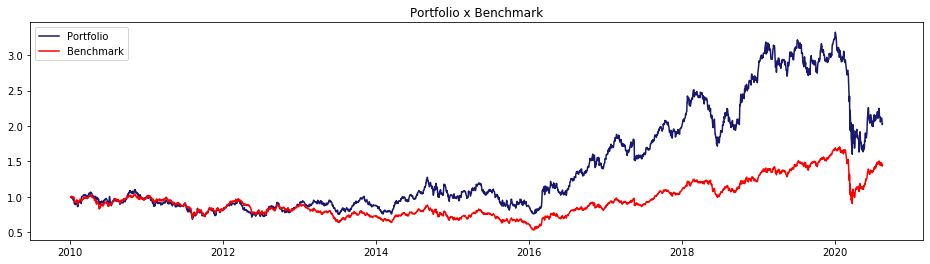

In [91]:
plt.figure(figsize=(16,4))
plt.plot(portfolio_cota,label='Portfolio',color='midnightblue')
plt.plot(benchmark_cota,label='Benchmark',color='Red')
plt.title('Portfolio x Benchmark')
plt.legend()
plt.show()


# Agora vamos aplicar as funções: 

**Retorno Anuzalizado:**

In [68]:
print('Retorno anualizado do portfolio: '+str(retorno_anualizado(portfolio_cota))
     ,'\nRetorno anualizado do benchmark: '+ str(retorno_anualizado(benchmark_cota)))

Retorno anualizado do portfolio: 0.07033458766340095 
Retorno anualizado do benchmark: 0.036161896725717124


**Máximo Drawdown:**

In [69]:
print('Máximo drawdown do portfolio: '+str(maximum_drawdown(portfolio_cota)),
     '\nMáximo drawdown do benchmark: '+str(maximum_drawdown(benchmark_cota)))

Máximo drawdown do portfolio: -0.5176913238411508 
Máximo drawdown do benchmark: -0.4863143185927996


**Volatilidade Anualizada:**

In [70]:
print('Volatilidade anualizada do portfolio: '+str(volatilidade_anualizada(portfolio_retornos_diarios)),
     '\nVolatilidade anualizada do benchmark: '+str(volatilidade_anualizada(benchmark_retornos_diarios)))

Volatilidade anualizada do portfolio: 0.32531334717082777 
Volatilidade anualizada do benchmark: 0.25331689434993865


**Underwater:**

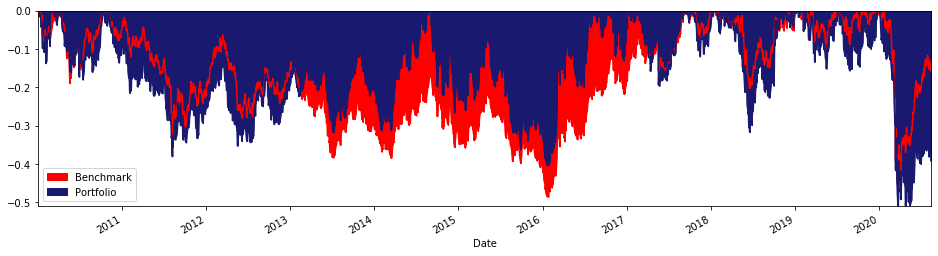

In [90]:
underwater_portfolio = drawdown_underwater(portfolio_cota)
underwater_benchmark = drawdown_underwater(benchmark_cota)
underwater_benchmark.plot.area(figsize=(16,4),alpha=1,label='Benchmark',color='Red')
underwater_portfolio.plot.area(figsize=(16,4),alpha=1,label='Portfolio',color='midnightblue')
plt.legend()
plt.show()

**Sharpe Ratio**

In [74]:
# Vamos utilizar a taxa livre de risco como sendo zero: 
retornos_diarios_taxa_livre_de_risco = portfolio_retornos_diarios.copy()
retornos_diarios_taxa_livre_de_risco[:]=0

print('Sharpe do portfolio: '+str(sharpe_ratio(portfolio_retornos_diarios,retornos_diarios_taxa_livre_de_risco)),
     '\nSharpe do benchmark: '+str(sharpe_ratio(benchmark_retornos_diarios,retornos_diarios_taxa_livre_de_risco)))

Sharpe do portfolio: 0.3716947443280887 
Sharpe do benchmark: 0.267874995836812


**Hit Ratio**

In [77]:
print('Hit ratio do portfolio: '+str(hit_ratio(portfolio_retornos_diarios)),
     '\nHit ratio do benchmark: '+str(hit_ratio(benchmark_retornos_diarios)))

Sharpe do portfolio: 0.5076335877862596 
Sharpe do benchmark: 0.5068702290076336


**Sortino Ratio**

In [81]:
# Vamos utilizar a taxa livre de risco como sendo zero: 
retornos_diarios_taxa_livre_de_risco = portfolio_retornos_diarios.copy()
retornos_diarios_taxa_livre_de_risco[:]=0

print('Sortino do portfolio: '+str(sortino_ratio(portfolio_retornos_diarios,retornos_diarios_taxa_livre_de_risco)),
     '\nSortino do benchmark: '+str(sortino_ratio(benchmark_retornos_diarios,retornos_diarios_taxa_livre_de_risco)))

Sortino do portfolio: 0.5415987390278321 
Sortino do benchmark: 0.35928009691431584


**Consistência**:

Para um k = 252, uma consistência de 0.72 significa que em 72% das janelas de 252 dias o retorno do portfolio superou o retorno do benchmark

In [87]:
print('Consistência do portfolio: '+str(consistencia(portfolio_cota,benchmark_cota,252)))

Consistência do portfolio: 0.7201350780920219
